In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.inspection import permutation_importance

# Ensure inline plotting
%matplotlib inline

# Set seaborn style
sns.set(style='whitegrid')

In [2]:
file_path = r'C:\Users\dell\Desktop\MyDocs\Docs\MK\steam_games.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
df.head()

,steam_appid,name,developers,publishers,categories,genres,required_age,n_achievements,platforms,is_released,...,additional_content,total_reviews,total_positive,total_negative,review_score,review_score_desc,positive_percentual,metacritic,is_free,price_initial (USD)
0,2719580,勇者の伝説の勇者,['ぽけそう'],['ぽけそう'],"['Single-player', 'Family Sharing']","['Casual', 'Indie']",0,0,['windows'],True,...,[],0,0,0,0.0,No user reviews,0.0,0,False,0.99
1,2719590,Light No Fire,['Hello Games'],['Hello Games'],"['Single-player', 'Multi-player', 'Co-op', 'On...","['Action', 'Adventure']",0,0,['windows'],False,...,[],0,0,0,0.0,No user reviews,0.0,0,False,0.00
2,2719600,Lorhaven: Cursed War,['GoldenGod Games'],['GoldenGod Games'],"['Single-player', 'Multi-player', 'PvP', 'Shar...","['RPG', 'Strategy']",0,32,"['windows', 'mac']",True,...,[],9,8,1,0.0,9 user reviews,88.9,0,False,9.99
3,2719610,PUIQ: Demons,['Giammnn'],['Giammnn'],"['Single-player', 'Steam Achievements', 'Famil...","['Action', 'Casual', 'Indie', 'RPG']",0,28,['windows'],True,...,[],0,0,0,0.0,No user reviews,0.0,0,False,2.99
4,2719650,Project XSTING,['Saucy Melon'],['Saucy Melon'],"['Single-player', 'Steam Achievements', 'Steam...","['Action', 'Casual', 'Indie', 'Early Access']",0,42,['windows'],True,...,[],9,9,0,0.0,9 user reviews,100.0,0,False,7.99


In [3]:
df.isnull().sum()

# Convert 'release_date' to datetime
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Fill missing values in 'metacritic' with the median
df['metacritic'].fillna(df['metacritic'].median(), inplace=True)

# Drop rows with missing 'release_date'
df.dropna(subset=['release_date'], inplace=True)

# Verify data types
df.dtypes

steam_appid                     int64
name                           object
developers                     object
publishers                     object
categories                     object
genres                         object
required_age                    int64
n_achievements                  int64
platforms                      object
is_released                      bool
release_date           datetime64[ns]
additional_content             object
total_reviews                   int64
total_positive                  int64
total_negative                  int64
review_score                  float64
review_score_desc              object
positive_percentual           float64
metacritic                      int64
is_free                          bool
price_initial (USD)           float64
dtype: object

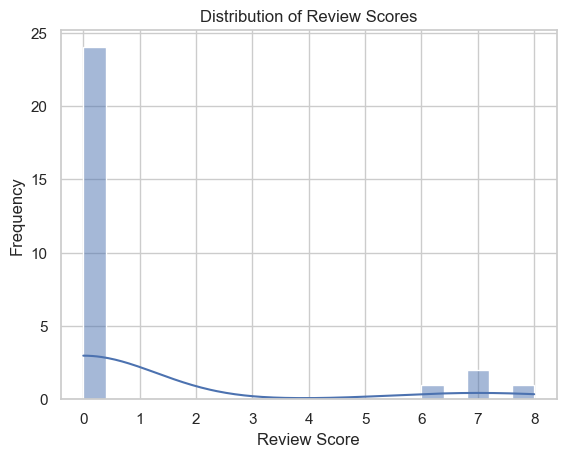

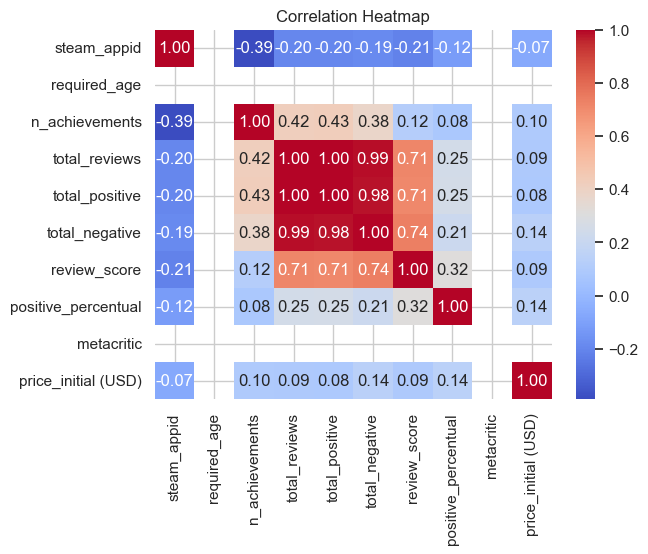

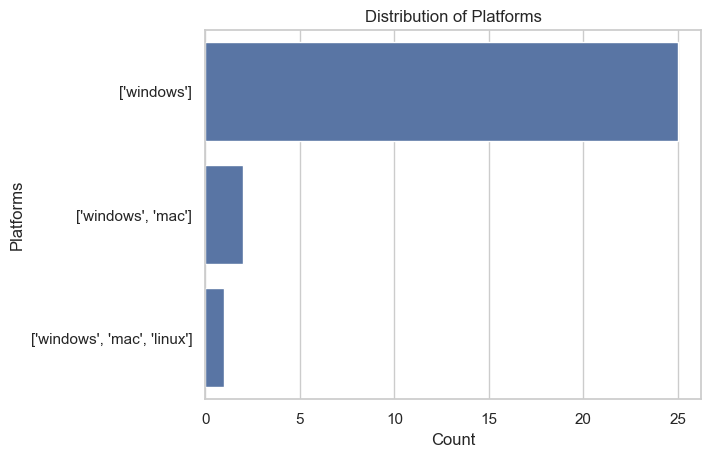

In [4]:
sns.histplot(df['review_score'], bins=20, kde=True)
plt.title('Distribution of Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.show()

# Correlation heatmap
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Platforms distribution
sns.countplot(y='platforms', data=df, order=df['platforms'].value_counts().index)
plt.title('Distribution of Platforms')
plt.xlabel('Count')
plt.ylabel('Platforms')
plt.show()

In [5]:
df['release_year'] = df['release_date'].dt.year

# Create a new feature: 'is_popular' based on positive reviews
df['is_popular'] = (df['positive_percentual'] > 75).astype(int)

# Display the first few rows with new features
df[['name', 'release_year', 'is_popular']].head()

,name,release_year,is_popular
0,勇者の伝説の勇者,2024,0
2,Lorhaven: Cursed War,2024,1
3,PUIQ: Demons,2024,0
4,Project XSTING,2024,1
7,Manor Madness,2024,0


Accuracy: 1.00


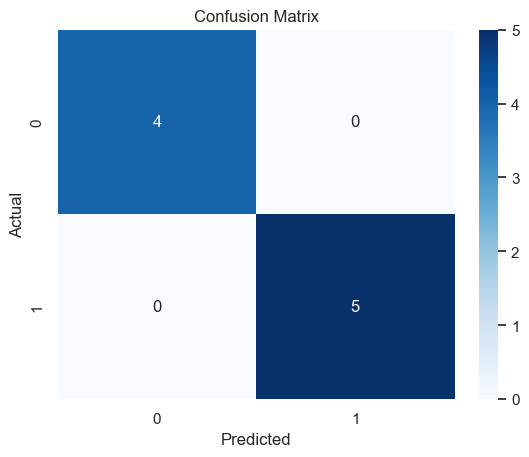

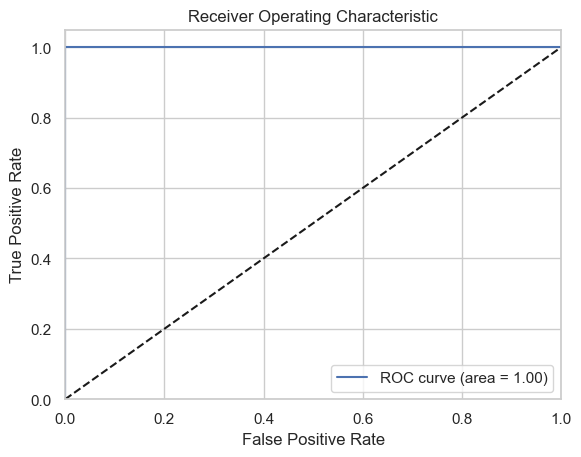

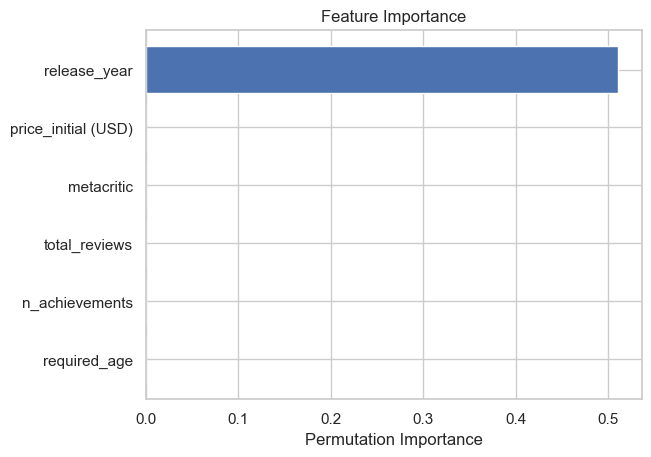

In [6]:
features = ['required_age', 'n_achievements', 'total_reviews', 'metacritic', 'price_initial (USD)', 'release_year']
X = df[features]
y = df['is_popular']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display accuracy
print(f'Accuracy: {accuracy:.2f}')

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Permutation Importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features, perm_importance.importances_mean[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance')
plt.show()